In [1]:
!pip install -q langchain-openai langchain playwright beautifulsoup4 html2text chromadb google-api-python-client networkx
!playwright install

130.8 MiB [                    ] 0% 0.0s130.8 MiB [                    ] 0% 341.0s130.8 MiB [                    ] 0% 471.4s130.8 MiB [                    ] 0% 520.8s130.8 MiB [                    ] 0% 543.5s130.8 MiB [                    ] 0% 583.0s130.8 MiB [                    ] 0% 575.4s130.8 MiB [                    ] 0% 519.1s130.8 MiB [                    ] 0% 517.4s130.8 MiB [                    ] 0% 527.9s130.8 MiB [                    ] 0% 441.5s130.8 MiB [                    ] 0% 433.5s130.8 MiB [                    ] 0% 452.2s130.8 MiB [                    ] 0% 434.5s130.8 MiB [                    ] 0% 448.9s130.8 MiB [                    ] 0% 413.0s130.8 MiB [                    ] 0% 447.9s130.8 MiB [                    ] 0% 415.5s130.8 MiB [                    ] 0% 389.3s130.8 MiB [                    ] 0% 364.4s130.8 MiB [                    ] 0% 360.4s130.8 MiB [                    ] 0% 369.1s130.8 MiB [                    ] 0% 328.9s130.8 MiB [                    ] 0% 

In [1]:
import dotenv
import nest_asyncio
nest_asyncio.apply()
dotenv.load_dotenv()

from langchain_community.document_loaders import AsyncChromiumLoader
from langchain_community.document_transformers import BeautifulSoupTransformer
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer

from langchain_openai import ChatOpenAI

from langchain.chains import create_extraction_chain

import pprint

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers.web_research import WebResearchRetriever
from langchain_community.utilities import GoogleSearchAPIWrapper
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [18]:

urls = [
# "https://www.asahi.com/sdgs/",
"https://www.bbc.com/news/science_and_environment",
"https://esgnews.com/",
"https://sustainabilitymag.com/esg",
"https://sustainablejapan.jp/news",
"https://esgjournaljapan.com/",
]

In [19]:
# Load HTML
loader = AsyncChromiumLoader(urls)
html = loader.load()

# Transform
bs_transformer = BeautifulSoupTransformer()
docs_transformed = bs_transformer.transform_documents(html, tags_to_extract=["span"])

# Result
docs_transformed[0].page_content[0:500]

"BBC Homepage Sign in Home News Sport Earth Reel Worklife Travel More menu More menu Search BBC Close menu BBC News Home Israel-Gaza war War in Ukraine Climate Video World Asia UK Business Tech Science Entertainment & Arts Health World News TV In Pictures BBC Verify Newsbeat Science What's the black gunk polluting the 'Bake Off' stream? Science & Environment 22 hours ago 22h 938 Should more British homes be built using straw? Business 22 hours ago 22h 336 England's hedges would go around Earth te"

Fetching pages: 100%|##########| 5/5 [00:04<00:00,  1.21it/s]


[Document(page_content='<!DOCTYPE html><html lang="en-GB" class="no-js"><head><meta charSet="utf-8" /><meta name="viewport" content="width=device-width, initial-scale=1" /><title data-rh="true">Science &amp; Environment | Latest News &amp; Updates | BBC News</title><meta data-rh="true" name="description" content="Get all the latest news, live updates and content about Science &amp; Environment from across the BBC."/><meta data-rh="true" name="theme-color" content="#FFFFFF"/><meta data-rh="true" property="fb:admins" content="100004154058350"/><meta data-rh="true" property="og:description" content="Get all the latest news, live updates and content about Science &amp; Environment from across the BBC."/><meta data-rh="true" property="og:image" content="https://www.bbc.co.uk/news/special/2015/newsspec_10857/bbc_news_logo.png"/><meta data-rh="true" property="og:image:alt" content="Logo for BBC News"/><meta data-rh="true" property="og:site_name" content="BBC News"/><meta data-rh="true" proper
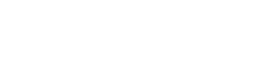

In [20]:
loader = AsyncHtmlLoader(urls)
docs = loader.load()
docs

In [21]:
html2text = Html2TextTransformer()
docs_transformed = html2text.transform_documents(docs)
docs_transformed[0].page_content[0:500]

'BBC Homepage\n\n  * Skip to content\n  * Accessibility Help\n\n  * Your account\n\n  * Home\n  * News\n  * Sport\n  * Earth\n  * Reel\n  * Worklife\n  * Travel\n  * More menu\n\nMore menu\n\nSearch BBC\n\n  * Home\n  * News\n  * Sport\n  * Earth\n  * Reel\n  * Worklife\n  * Travel\n  * Culture\n  * Future\n  * Music\n  * TV\n  * Weather\n  * Sounds\n\nClose menu\n\nBBC News\n\nMenu\n\n  * Home\n  * Israel-Gaza war\n  * War in Ukraine\n  * Climate\n  * Video\n  * World\n  * Asia\n  * UK\n  * Business\n  * Tech\n\nMore\n\n  * Science\n  * Entertainme'

In [23]:

schema = {
    "properties": {
        "news_article_title": {"type": "string"},
        "news_article_summary": {"type": "string"},
    },
    "required": ["news_article_title", "news_article_summary"],
}

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613")

def extract(content: str, schema: dict):
    return create_extraction_chain(schema=schema, llm=llm).run(content)

In [24]:


def scrape_with_playwright(urls, schema):
    loader = AsyncChromiumLoader(urls)
    docs = loader.load()
    bs_transformer = BeautifulSoupTransformer()
    docs_transformed = bs_transformer.transform_documents(
        docs, tags_to_extract=["span"]
    )
    print("Extracting content with LLM")

    # Grab the first 1000 tokens of the site
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=1000, chunk_overlap=0, add_start_index=True
    )
    splits = splitter.split_documents(docs_transformed)

    # Process the first split
    extracted_content = extract(schema=schema, content=splits[0].page_content)
    pprint.pprint(extracted_content)
    return extracted_content

extracted_content = scrape_with_playwright(urls, schema=schema)

Extracting content with LLM


/Users/tmina/anaconda3/envs/myenv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


[{'news_article_summary': 'Science & Environment 22 hours ago 22h 938',
  'news_article_title': "What's the black gunk polluting the 'Bake Off' "
                        'stream?'},
 {'news_article_summary': 'Business 22 hours ago 22h 336',
  'news_article_title': 'Should more British homes be built using straw?'},
 {'news_article_summary': 'Science & Environment 3 days ago 3d',
  'news_article_title': "England's hedges would go around Earth ten times"},
 {'news_article_summary': 'Science & Environment 3 days ago 3d',
  'news_article_title': 'Young science writer award goes national'},
 {'news_article_summary': 'Science & Environment 4 days ago 4d',
  'news_article_title': "'Toy poodles' on the Moon: Japan lander gets to work"},
 {'news_article_summary': 'Devon 4 days ago 4d',
  'news_article_title': 'Mass tree planting to recreate lost rainforest'},
 {'news_article_summary': 'US & Canada 5 days ago 5d',
  'news_article_title': "World's largest cruise ship sets sail from Miami"},
 {'ne

In [6]:
# Vectorstore
vectorstore = Chroma(
    embedding_function=OpenAIEmbeddings(), persist_directory="./chroma_db_oai"
)

# LLM
llm = ChatOpenAI(temperature=0)

# Search
search = GoogleSearchAPIWrapper()

In [7]:
# Initialize
web_research_retriever = WebResearchRetriever.from_llm(
    vectorstore=vectorstore, llm=llm, search=search
)

In [8]:
# Run
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.web_research").setLevel(logging.INFO)
from langchain.chains import RetrievalQAWithSourcesChain

user_input = "How do LLM Powered Autonomous Agents work?"
qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm, retriever=web_research_retriever
)
result = qa_chain({"question": user_input})
result

/Users/tmina/anaconda3/envs/myenv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
INFO:langchain.retrievers.web_research:Generating questions for Google Search ...
INFO:langchain.retrievers.web_research:Questions for Google Search (raw): {'question': 'How do LLM Powered Autonomous Agents work?', 'text': LineList(lines=['1. What is the functioning principle of LLM Powered Autonomous Agents?\n', '2. How do LLM Powered Autonomous Agents operate?\n', '3. Can you explain the working mechanism of LLM Powered Autonomous Agents?'])}
INFO:langchain.retrievers.web_research:Questions for Google Search: ['1. What is the functioning principle of LLM Powered Autonomous Agents?\n', '2. How do LLM Powered Autonomous Agents operate?\n', '3. Can you explain the working mechanism of LLM Powered Autonomous Agents?']
INFO:langchain.

{'question': 'How do LLM Powered Autonomous Agents work?',
 'answer': "LLM-powered autonomous agents work by using LLM as the agent's brain, complemented by several key components such as planning, memory, and tool use. The planning component involves task decomposition and self-reflection. The memory component includes short-term memory and long-term memory. The tool use component allows the agent to call external APIs for additional information. LLM-powered agents have been used in various applications, including scientific discovery and generative agents simulation. They have the potential to be powerful general problem solvers. \n",
 'sources': ''}

In [25]:
from langchain.indexes import GraphIndexCreator
from langchain_openai import OpenAI

In [26]:
index_creator = GraphIndexCreator(llm=OpenAI(temperature=0))



In [27]:
text = 'It won’t look like much, but if you stop and look closely, you’ll see a “Field of dreams,” the ground on which America’s future will be built. \nThis is where Intel, the American company that helped build Silicon Valley, is going to build its $20 billion semiconductor “mega site”. \nUp to eight state-of-the-art factories in one place. 10,000 new good-paying jobs. '

In [30]:
graph = index_creator.from_text(text)



In [31]:
from langchain.chains import GraphQAChain

chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)

chain.run("what is Intel going to build?")





> Entering new GraphQAChain chain...
Entities Extracted:
 Intel
Full Context:
Intel is going to build $20 billion semiconductor “mega site”
Intel helped build Silicon Valley
Intel is going to build 8 state-of-the-art factories
Intel is going to create 10,000 new good-paying jobs

> Finished chain.


' Intel is going to build a $20 billion semiconductor "mega site" and 8 state-of-the-art factories.'